# Image Classification

The goal of this notebook is to have an initial setup for image classification. Basically you only have to change the configurations (like dataset, image specs, etc), and the rest will automatically set.

This notebook is inspired on:
- https://www.tensorflow.org/tutorials/images/classification

Install 3rd party packages

In [1]:
# tensorflow for apple macbook pro m1 chip
!pip install tensorflow==2.10.0 tensorflow-io==0.27.0

# remaining dependencies
!pip install matplotlib mlflow

  Using cached tensorflow-2.10.0-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (1.9 kB)
  Using cached tensorflow_io-0.27.0-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (36.9 MB)
  Using cached matplotlib-3.6.1-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (11.6 MB)
  Using cached mlflow-1.29.0-py3-none-any.whl (16.9 MB)
  Using cached tensorflow_cpu_aws-2.10.0-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (213.8 MB)
  Using cached tensorflow_io_gcs_filesystem-0.27.0-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (2.8 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached libclang-14.0.6-py2.py3-none-manylinux2014_aarch64.whl (12.6 MB)
  Using cached h5py-3.7.0-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (8.3 MB)
  Using cached termcolor-2.0.1-py3-none-a

In [2]:
# python core packages
import pathlib

# 3rd party packages
import PIL
import mlflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Configuration

In [3]:
# where are the images?
data_dir = pathlib.Path('../datasets/image_classification/multiclass/flower_photos')

# how large are the batches?
batch_size = 32

# How long do you want to train?
epochs = 10

# which images dimensions do we want?
img_height = 180
img_width = 180
img_channels = 3

# what seed do you want?
seed = 123

## Settings

In [4]:
mlflow.set_experiment("image_classification")
mlflow.tensorflow.autolog()

if img_channels == 1:
    color_mode = 'grayscale'
    cmap = 'gray'

if img_channels == 3:
    color_mode = 'rgb'
    cmap = 'viridis'
    
if img_channels == 4:
    color_mode = 'rgba'
    cmap = 'viridis'

## Data

Load the training data

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode=color_mode
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


Load the validation data

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode=color_mode
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Which classnames

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"- Found {num_classes} classes: {class_names}")

- Found 5 classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Examples

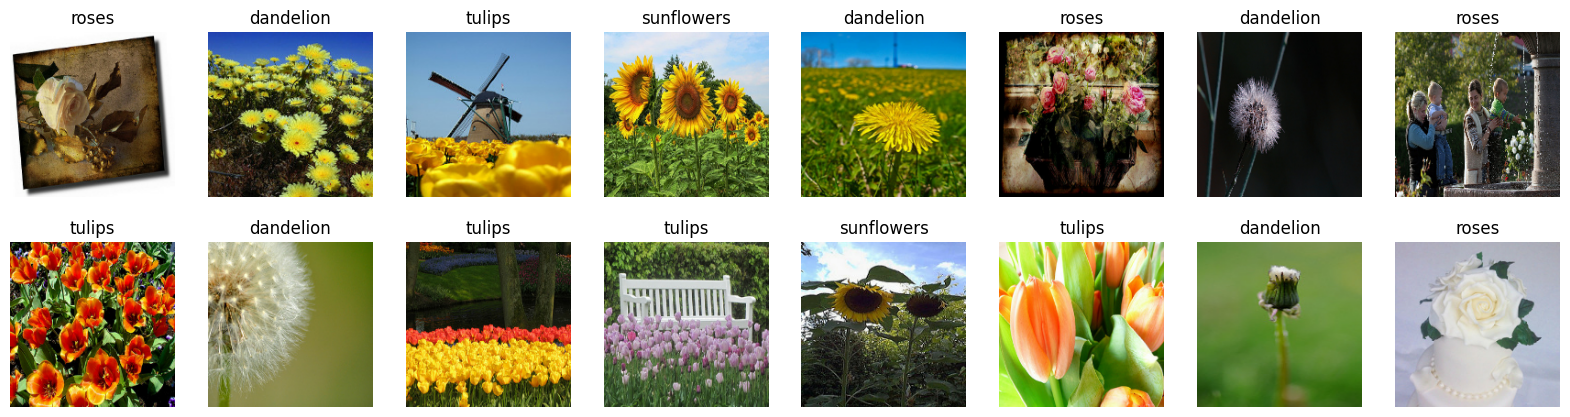

In [8]:
plt.figure(figsize=(20, 5))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(2, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap=cmap)
        plt.title(class_names[labels[i]])
        plt.axis("off")

What do the tensors look like?

In [9]:
for image_batch, labels_batch in train_ds:
    print(f"- Image tensor shape:\t(batch, height, width, channels)\t{image_batch.shape}")
    print(f"- Labels tensor shape:\t(batch,)\t\t\t\t{labels_batch.shape}")
    break

- Image tensor shape:	(batch, height, width, channels)	(32, 180, 180, 3)
- Labels tensor shape:	(batch,)				(32,)


Now let's tune for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize

In [11]:
first_image = image_batch[0]

print(f"- The image value range: [{np.min(first_image)}, {np.max(first_image)}]")

- The image value range: [0.0, 255.0]


## Model

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, img_channels)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Training

In [13]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

2022/10/18 20:21:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd302beb0048044a48b33871a44aa6737', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
92/92 [==============================] - 19s 180ms/step - loss: 1.3245 - accuracy: 0.4271 - val_loss: 1.1364 - val_accuracy: 0.5327
Epoch 2/10
92/92 [==============================] - 16s 176ms/step - loss: 1.0145 - accuracy: 0.6046 - val_loss: 0.9782 - val_accuracy: 0.6172
Epoch 3/10
92/92 [==============================] - 16s 176ms/step - loss: 0.8273 - accuracy: 0.6894 - val_loss: 0.8748 - val_accuracy: 0.6594
Epoch 4/10
92/92 [==============================] - 17s 181ms/step - loss: 0.6077 - accuracy: 0.7728 - val_loss: 0.9485 - val_accuracy: 0.6526
Epoch 5/10
92/92 [==============================] - 16s 178ms/step - loss: 0.3918 - accuracy: 0.8665 - val_loss: 1.1367 - val_accuracy: 0.6403
Epoch 6/10
92/92 [==============================] - 16s 179ms/step - loss: 0.2292 - accuracy: 0.9186 - val_loss: 1.2665 - val_accuracy: 0.6403
Epoch 7/10
92/92 [==============================] - 16s 177ms/step - loss: 0.1333 - accuracy: 0.9625 - val_loss: 1.4411 - val_accuracy: 0.6567

INFO:tensorflow:Assets written to: /tmp/tmpoid_3c_i/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpoid_3c_i/model/data/model/assets
2022/10/18 20:24:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


Results

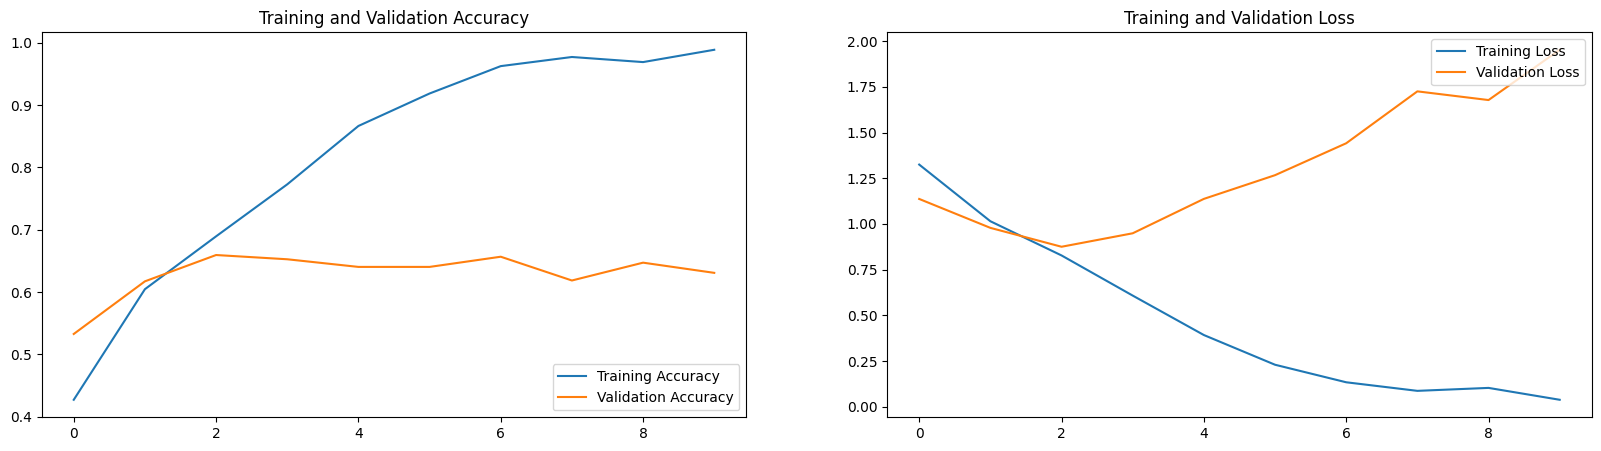

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()